## Step 1 - Getting the point cloud and Computing Vietoris-Rips Complexes and Cohomology

Populating the interactive namespace from numpy and matplotlib


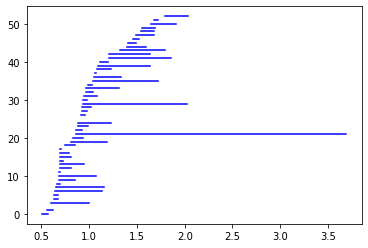

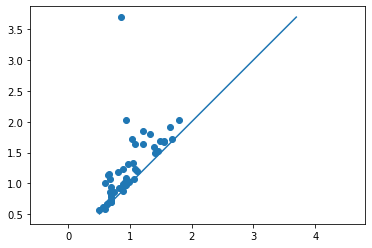

In [28]:
%pylab inline
import examples as eg
import numpy as np
from numpy import *
import dionysus

points = eg.pinched_torus_example(n=200)
#The examples.py generates data points in form of point clouds that can be analyzed using the imported dionysus module.
prime = 11 #choose the prime base for the coefficient field that we use to construct the persistence cohomology.

vr = dionysus.fill_rips(points, 2, 4.) #Vietoris-Rips complex up to dimension 2 and maximal distance 4
cp = dionysus.cohomology_persistence(vr, prime, True) #Create the persistent cohomology based on the chosen parameters.
dgms = dionysus.init_diagrams(cp, vr) #Calculate the persistent diagram using the designated coefficient field and complex.
dionysus.plot.plot_bars(dgms[1], show=True) 
dionysus.plot.plot_diagram(dgms[1], show=True) 
#dionysus.plot.plot_diagram(dgms[0], show=True) 
#Plot the barcode and diagrams using matplotlib incarnation within Dionysus2. This mechanism is different in Dionysus.

## Step 2 - Selecting the cocycle and visualization.

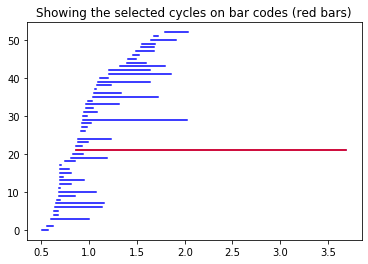

[0.8609931468963623, 3.6933929920196533]
[0.9330045580863953, 2.0260298252105713]


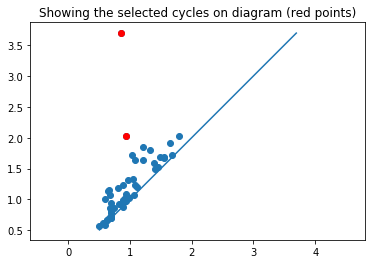

In [29]:
threshold = 1
bars = [bar for bar in dgms[1] if bar.death-bar.birth > threshold] #choosing cocycle that persist at least threshold=1.
cocycles = [cp.cocycle(bar.data) for bar in bars]
#plt is the matplotlib incarnation.

#Red highlight cocyles that persist more than threshold value on barcode, when more than one cocyles have persisted over threshold values, this plots the first one.
dionysus.plot.plot_bars(dgms[1], show=False)
plt.plot([[bar.birth,bar.death] for bar in dgms[1] if bar.death-bar.birth > threshold][0],[[x,x] for x,bar in enumerate(dgms[1]) if bar.death-bar.birth > threshold][0],'r')
plt.title('Showing the selected cycles on bar codes (red bars)')
plt.show()

#Red highlight ***ALL*** cocyles that persist more than threshold value on diagram.
dionysus.plot.plot_diagram(dgms[1], show=False)
Lt1 = [[point.birth,point.death] for point in dgms[1] if point.death-point.birth > threshold] 
for Lt3 in Lt1:
    print(Lt3)
    plt.plot(Lt3[0],Lt3[1],'ro')
plt.title('Showing the selected cycles on diagram (red points)')
plt.show()
chosen_cocycle= cocycles[0]
chosen_bar= bars[0]

## Step 3 - Display the scatter points sampled from the manifold

In [30]:
'''
prime = 23
f = dionysus.fill_rips(points, 2, 4.)
p = dionysus.cohomology_persistence(f, prime, True)
dgms = dionysus.init_diagrams(p, f)
'''
pt = max(dgms[1], key = lambda pt: pt.death - pt.birth)
print(pt)
chosen_cocycle = cp.cocycle(pt.data)
#fill_rips() computes Vietoris–Rips filtrations (up to a specified skeleton dimension and distance r).

(0.860993,3.69339)


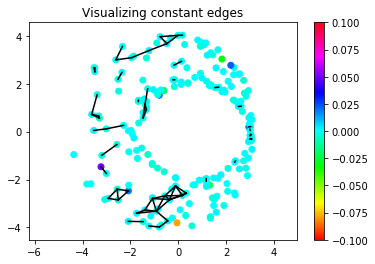

In [32]:
#If it is computed the smoothed coefficients can be used as initial condition for the optimization code
#hrluo: However, this optimization problem seems extremely sensitive to the initialization, the choice of L^2 smoothed coordinates does not seem to be 
vr_complex = dionysus.Filtration([s for s in vr if s.data <= max([bar.birth for bar in bars])])
coords = dionysus.smooth(vr_complex, chosen_cocycle, prime)
##To smooth the cocycle and convert it to the corresponding *circular coordinates*, we need to choose a complex, 
##in which we do the smoothing. 
##Here we select the complex in the filtration that exists at the midvalue of the persistence bar, (pt.death + pt.birth)/2:
##or the complex with the maximal birth
'''
https://mrzv.org/software/dionysus2/tutorial/cohomology.html
'''

toll = 1e-5
p,val = (chosen_bar,coords)

#Show the constant edges first.
edges_costant = []
thr = p.birth # i want to check all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
    if abs(val[s[0]]-val[s[1]]) <= toll:
        edges_costant.append([points[s[0],:],points[s[1],:]])
edges_costant = np.array(edges_costant)
plot(edges_costant.T[0,:],edges_costant.T[1,:], c='k')
#Now we can plot the points using hue to show the circular coordinate
plt.scatter(points[:,0], points[:,1], c = coords_restricted, cmap = 'hsv')
plt.clim(-.1, .1)
plt.colorbar()
plt.axis('equal')
plt.title('Visualizing constant edges')
plt.show()


## Step 5 - Second smoothing using a new cost function

In [ ]:
import utils
l2_cocycle,f,bdry = utils.optimizer_inputs(vr, bars, chosen_cocycle, coords, prime)
#l2_cocycle.reshape(-1, 1)
l2_cocycle = l2_cocycle.reshape(-1, 1)
np.zeros(l2_cocycle.shape[0])
l2_cocycle.shape
f-bdry*l2_cocycle

l2_cocycle.shape
ZV = np.zeros(l2_cocycle.shape[0])
ZV = ZV.reshape(l2_cocycle.shape[0],1)
ZV.shape

In [ ]:
import tensorflow as tf
#import tensorflow_probability as tfp
'''Following seems deprecated in newer version of tfp
#pip install --upgrade tensorflow-probability==0.70
#alternatively, we can use tensorflow to minimize the cost function without gradient information, here we can use multiple black-box functions like Adams
#For more: Check at https://www.tensorflow.org/probability/api_docs/python/tfp/math/minimize
x = tf.Variable(0.)
cost_fun = lambda: cost_functions.cost_Lpnorm_mvj(x, F= f, B= bdry, p= 20)
res_tfp=tfp.math.minimize(
        cost_fun,
        num_steps=1000,
        optimizer=tfp.optimizers.Adam(learning_rate=0.1)
        )
'''
#Following seems working, c.f. 
#https://stackoverflow.com/questions/55552715/tensorflow-2-0-minimize-a-simple-function
def cost(z):
    import cost_functions
    return cost_functions.cost_Lpnorm_mvj(z, F= f, B= bdry, p= 20)
#type(bdry)
#scipy.sparse.csr.csr_matrix
B_mat = bdry.todense()
import tensorflow as tf
#print(f.shape)
#print((B_mat*l2_cocycle).shape)
z = tf.Variable(ZV, trainable=True)
# z is a tensorflow trainable variable with initial value as a zero vector of l2_cocycle length, this would be updated consecutively.

###L1 in tensorflow language
#cost_z = tf.reduce_sum( tf.abs(f - B_mat @ z) )
###L2 in tensorflow language
#cost_z = tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),2 ) )
#Lp+alpha*Lq norm in tensorflow language
lp=2
lq=1
alpha=0
cost_z = (1-alpha)*tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lp ) ), 1/lp) + alpha* tf.pow( tf.reduce_sum( tf.pow( tf.abs(f - B_mat @ z),lq ) ), 1/lq)

#Gradient Descedent Optimizer
opt_gd = tf.train.GradientDescentOptimizer(0.1).minimize(cost_z)
#Adams Optimizer
opt_adams = tf.train.AdamOptimizer(0.1).minimize(cost_z)
#The latter is much better in terms of result

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(2000):#How many iterations you want to run?
        #print(sess.run([x,loss]))
        sess.run(opt_adams)
        #Key choice of optimizer
    res_tf=sess.run([z,cost_z])
#type(res_tf)
#print(res_tf)
res_tf=res_tf[0]
#res_tf
color = np.mod(res_tf.T[0,:],1)
'''
scatter(points.T[0,:],points.T[1,:],s=20, c=color, cmap="hsv")
#scatter(*points.T, c= color, cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('Smoothed values mod 1 - {}*L{} + {}*L{} elastic norm with TensorFlow'.format(1-alpha,lp,alpha,lq))
plot(edges_constant.T[0,:],edges_constant.T[1,:], c='k')
plt.show()
'''
toll = 1e-5
edges_constant = []
thr = chosen_bar.birth # i want to check constant edges in all edges that were there when the cycle was created
for s in vr:
    if s.dimension() != 1:
        continue
    elif s.data > thr:
        break
    if abs(color[s[0]]-color[s[1]]) <= toll:
        edges_constant.append([points[s[0],:],points[s[1],:]])
edges_constant = np.array(edges_constant)        
#scatter(*points.T, c=color, cmap="hsv", alpha=.5)
scatter(points.T[0,:],points.T[1,:],s=20, c=color, cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('Smoothed values mod 1 - {}*L{} + {}*L{} elastic norm with TensorFlow'.format(1-alpha,lp,alpha,lq))
#plot(*edges_constant.T, c='k')
plot(edges_constant.T[0,:],edges_constant.T[1,:], c='k', alpha=0.1)
edges_constant.shape
plt.savefig('pqSmoothedValueMod1_{}_L{}+{}_L{}TF.png'.format(1-alpha,lp,alpha,lq))
plt.show()